In [1]:
import sys
import glob
import os
import xml
import cv2
import numpy as np

sys.path.insert(0, '../src/')

import window_extraction
import config
import character_recognition as cr

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

In [70]:
image_files = glob.glob(os.path.join(config.TEST_IMAGE_PATH, '*.png'))
prediction_files100 = glob.glob(os.path.join(config.TEST_IMAGE_PATH + "/dic100m100/", '*.npy'))
prediction_files200 = glob.glob(os.path.join(config.TEST_IMAGE_PATH + "/dic200m200/", '*.npy'))
prediction_files500 = glob.glob(os.path.join(config.TEST_IMAGE_PATH + "/dic500m500/", '*.npy'))
prediction_files700 = glob.glob(os.path.join(config.TEST_IMAGE_PATH + "/dic700m700/", '*.npy'))
#prediction_files1000 = glob.glob(os.path.join(config.TEST_IMAGE_PATH + "/dic1000m1000/", '*.npy'))

In [60]:
def get_predictions(prediction_files):
    
    predictions = {}

    for i, prediction in enumerate(prediction_files):

        #f, axarr = plt.subplots(1, 3)

        original_img = cv2.imread(image_files[i])
        #axarr[0].imshow(original_img)

        predicted_img = np.load(prediction)
        #axarr[1].imshow(predicted_img)

        # activate / deactivate threshold
        #predicted_img[np.where(predicted_img < 140)] = 0
        #predicted_img[np.where(predicted_img >= 140)] = 1
        #axarr[2].imshow(predicted_img)

        image_name = image_files[i].split('/')[-1].split('.')[0]
        predictions[image_name] = predicted_img

        #plt.show() 
    
    return predictions

In [61]:
predictions_list = []

In [62]:
predictions_list.append(get_predictions(prediction_files100))
predictions_list.append(get_predictions(prediction_files200))
predictions_list.append(get_predictions(prediction_files500))
predictions_list.append(get_predictions(prediction_files700))

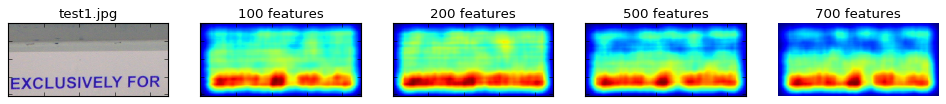

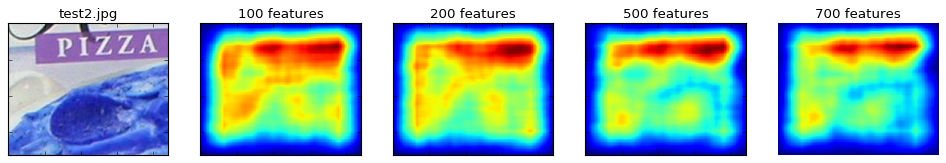

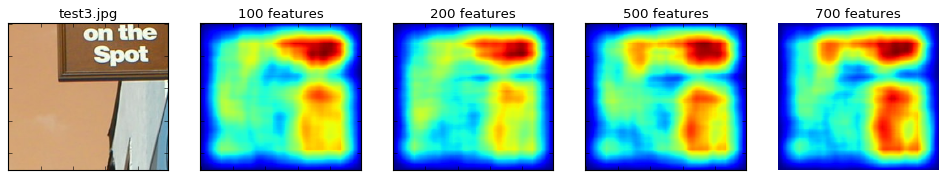

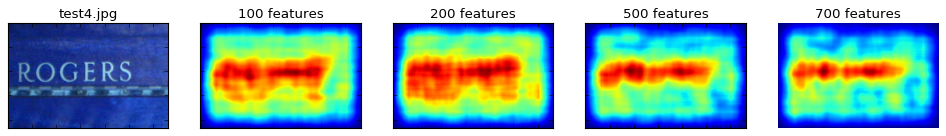

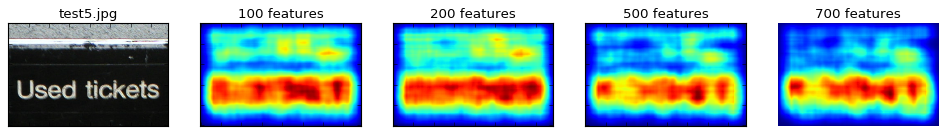

In [63]:
labels = ['100', '200', '500', '700']

for image in image_files:
    f, axarr = plt.subplots(1, 5, figsize=(15, 5))
    plt.axis('off')
    
    image_name = image.split('/')[-1].split('.')[0]
    
    original_img = cv2.imread(image)
    
    axarr[0].imshow(original_img)
    axarr[0].set_title(image.split('/')[-1])
    axarr[0].set_yticklabels([])
    axarr[0].set_xticklabels([])
    
    for i, prediction in enumerate(predictions_list):
        pred = prediction[image_name]
        #predicted_img = np.load(pred)
        axarr[i + 1].imshow(pred)
        axarr[i + 1].set_title(labels[i] + ' features')
        axarr[i + 1].set_yticklabels([])
        axarr[i + 1].set_xticklabels([])

# Label Images

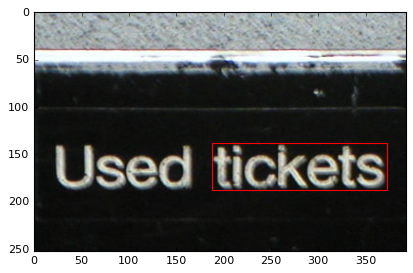

In [64]:
img = cv2.imread(image_files[4])
fig,ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((188, 138), 185, 50,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

# get Text Boxes

In [65]:
def get_text_boxes(path, plot=True):
    # parse xml
    e = xml.etree.ElementTree.parse(path).getroot()
    dic = window_extraction.parse_xml(e)

    original_text = {}

    # iterate over images
    for image in dic.items():
        image_name = image[0].split('.')[0]

        # initialize img
        res = image[1][0]
        shape = (int(res['y']), int(res['x']))
        img = np.zeros(shape)
        
        # mark textboxes with label 1
        for box in image[1][1]:
            x = int(box['x'])
            width = int(box['width'])
            y = int(box['y'])
            height = int(box['height'])
            img[y:y + height, x:x + width] = 1

        original_text[image_name] = img
        
        if plot:
            print(image_name)
            plt.imshow(img)
            plt.show()
        
    return original_text
    

In [66]:
path = '../data/test_images/test_set/locations.xml'
original_text = get_text_boxes(path, False)

# precision-recall

In [67]:
def get_curve_values(preds, original):
    y_true = []
    y_scores = []
    
    # iterate over predictions
    for name, img in preds.items():

        y_scores.append(img.flatten())
        y_true.append(original[name].flatten())


    y_true = [item for sublist in y_true for item in sublist]
    y_pred = [item for sublist in y_scores for item in sublist]

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred, average="micro")

    return precision, recall, average_precision


In [68]:
def get_precision_recall_curves(predictions_list, original_text):
    
    plt.figure(figsize=(10, 6))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    labels = ['100', '200', '500', '700']
    colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']

    for i, predictions in enumerate(predictions_list):
        precision, recall, average_precision = get_curve_values(predictions, original_text)
        plt.plot(recall, precision, lw=1.5, color=colors[i], label='{0} features; AUC: {1:0.2f}'.format(labels[i], average_precision))

    plt.legend(loc=0)
    plt.show()

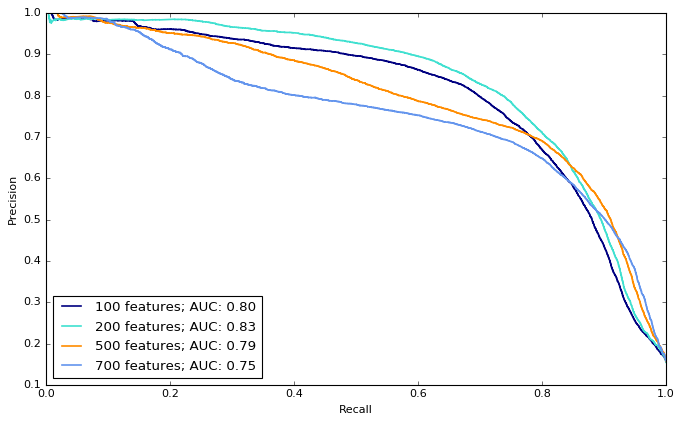

In [69]:
get_precision_recall_curves(predictions_list, original_text)